# <font style="color:#313151" face="Helvetica" > pyiron-continuum </font>

---


<table border="0">
 <tr>
    <td style="width:60%"> <p style="width:100% color:gray;font-size:18px;text-align:right"> <a href="https://github.com/pyiron/pyiron_continuum">pyiron-continuum</a> provides integrations for continuum tools enabling seamless cross-code workflows from jupyter notebooks.</p> </td>
    <td style="width:40%"><img src="img/logo.png" width="50%" align="justify"></td>
  </tr>
</table>


<table border="0">
 <tr>
    <td style="width:40%"><img src="img/fenics_banner.png" width="100%" align="justify"></td>
    <td style="width:60%"> <p style="width:100% color:gray;font-size:18px;text-align:justify"> FEniCS is a popular open-source computing platform for solving partial differential equations (PDEs). FEniCS enables users to quickly translate scientific models into efficient finite element code.</p> </td>
 </tr>
</table>

---

## <font style="color:#313151" face="Helvetica" > Solving the Poisson equation </font>

Poisson equation is fundamental equation. It can be formulated as,

$$
- \nabla^2 u(\pmb{x}) = f(\pmb{x}),~\pmb{x}~\mathrm{in}~\Omega \\
u(\pmb{x}) = u_D(\pmb{x}),~\pmb{x}~\mathrm{on}~\partial\Omega
$$

In two dimensions, the equation can be written as,

$$
- \frac{\partial^2 u}{\partial x^2} - \frac{\partial^2 u}{\partial y^2} = f(x, y)
$$




In [1]:
from pyiron_base import Project
import pyiron_continuum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pr = Project('fenics_tutorial')
pr.remove_jobs(silently=True, recursive=True)

In [3]:
job = pr.create.job.Fenics('poisson', delete_existing_job=True)

/home/sarath/miniconda3/envs/pyiron-demonstration2/lib/python3.9/site-packages/pyiron_continuum-0.0.5.post0.dev23-py3.9.egg/pyiron_continuum/fenics/job/generic.py:123: UserWarning: Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file. This includes the domains, boundary condition, spatial functions. Therefore, it is not possible to reload the job properly, from HDF5 file. It would be safe to remove the Fenics jobs, after defining the project.
  warnings.warn("Currently, the c++ dolfin functions used by fenics are not stored in the HDF5 file."


### Step 1: Identify the domain

In [4]:
job.domain = job.create.domain.unit_mesh.square(8, 8)

### Step 2: Assign boundary conditions

For the purpose of demonstration, we use a simple quadratic function:

$$
u_e(x, y) = 1 + x^2 + 2 y^2
$$

By inserting it back into Poisson equation, we can say that $u_e$ is a solution if,

$f(x, y)=-6,~u_D(x, y)=u_e(x, y)=1 + x^2 + 2 y^2$

In [5]:
u_D = job.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

Assign boundary conditions now

In [6]:
job.BC = job.create.bc.dirichlet(u_D)

Calling FFC just-in-time (JIT) compiler, this may take some time.


### Step 3: specify the variational equation

In [8]:
job.LHS = job.dot(job.grad_u, job.grad_v) * job.dx
job.RHS = job.Constant(-6.0) * job.v * job.dx

And run

In [9]:
job.run()

The job poisson was saved and received the ID: 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


### Step 4: Visualise the results

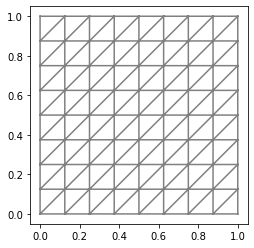

In [10]:
job.plot.mesh()

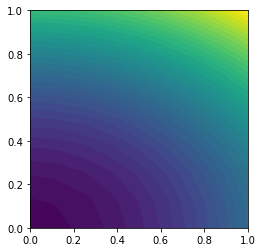

In [11]:
job.plot.solution()

Compute maximum error at the vertices

In [12]:
error_L2 = job.fenics.errornorm(u_D, job.solution, 'L2')

vertex_values_u_D = u_D.compute_vertex_values(job.mesh)
vertex_values_u = job.output.solution[-1]

print('error_L2  =', error_L2)
print('error_max =', np.max(np.abs(vertex_values_u_D - vertex_values_u)))

Calling FFC just-in-time (JIT) compiler, this may take some time.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


Equivalent python code

```python
from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u)
plot(mesh)

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
plt.show()
```